In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pywt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [32]:
# 1.1. Función para aplicar denoising usando wavelet
def aplicar_wavelet_denoising(datos, wavelet='sym4', nivel=4, mode='soft'):
    coeficientes = pywt.wavedec(datos, wavelet, level=nivel)
    sigma = np.median(np.abs(coeficientes[-1])) / 0.6745  # Estimación robusta del ruido
    umbral = sigma * np.sqrt(2 * np.log(len(datos))) * 1.5  # Ajuste del umbral
    coeficientes[1:] = [pywt.threshold(c, value=umbral, mode=mode) for c in coeficientes[1:]]
    señal_reconstruida = pywt.waverec(coeficientes, wavelet)
    return señal_reconstruida

In [33]:
# 1. Cargar datos desde archivos CSV
def load_and_denoise_csv_data(data_dir):
    records = []
    labels = []
    label_map = {'infarto': 0, 'NORM': 1}
    for label_name, label_idx in label_map.items():
        folder_list = ['IMI', 'ILMI'] if label_name == 'infarto' else [label_name]
        for folder in folder_list:
            folder_path = os.path.join(data_dir, folder)
            for file in os.listdir(folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(folder_path, file)
                    signal = pd.read_csv(file_path, header=None, encoding="ansi", skiprows=2).values.flatten()
                    denoised_signal = aplicar_wavelet_denoising(signal)
                    records.append(denoised_signal)
                    labels.append(label_idx)
    return np.array(records, dtype=object), np.array(labels), label_map




In [34]:
# 2.1. Preprocesar los datos
def extract_wavelet_features(signal, wavelet='sym4', level=6):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    for coeff in coeffs:
        features.extend([np.mean(coeff), np.std(coeff), np.max(coeff), np.min(coeff), np.median(coeff)])
    return np.array(features)


In [35]:
# 2. Preprocesar los datos
def preprocess_data(records, labels, num_classes):
    feature_records = [extract_wavelet_features(signal) for signal in records]
    feature_records = np.array(feature_records)
    feature_records = (feature_records - np.min(feature_records, axis=1, keepdims=True)) / \
                      (np.max(feature_records, axis=1, keepdims=True) - np.min(feature_records, axis=1, keepdims=True))
    feature_records = np.expand_dims(feature_records, axis=-1)
    labels = to_categorical(labels, num_classes)
    return feature_records, labels

In [36]:
# 3. Dividir los datos en entrenamiento y validación
def split_data(records, labels, test_size=0.15, val_size=0.15):
    X_train_val, X_test, y_train_val, y_test = train_test_split(records, labels, test_size=test_size, stratify=labels, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [37]:
def build_alexnet(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=11, strides=2, padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(512, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax'),
    ])
    return model



In [38]:
# 5. Entrenar el modelo con callbacks
def train_model(model, x_train, y_train, x_val, y_val, batch_size=32, epochs=50, learning_rate=0.0001):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model.compile(optimizer=optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    return history

In [39]:
# 6. Evaluación con métricas detalladas
def evaluate_model(model, x_test, y_test, class_names):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true, y_pred_classes)
    print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
    print("\nConfusion Matrix:\n", cm)
    print(f"\nF1-Score (weighted): {f1:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    return cm, f1, recall


In [40]:
# 7. Visualización de entrenamiento
def plot_training(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


In [41]:
import random

def augment_signal(signal, augmentation_type):
    """
    Aplica técnicas de aumento de datos a una señal ECG.
    
    Parameters:
        signal (array): La señal ECG original.
        augmentation_type (str): El tipo de aumento a aplicar ('noise', 'stretch', 'amplitude').
        
    Returns:
        array: La señal aumentada.
    """
    if augmentation_type == 'noise':
        noise = np.random.normal(0, 0.01, len(signal))  # Añadir ruido blanco
        return signal + noise
    elif augmentation_type == 'stretch':
        factor = random.uniform(0.8, 1.2)  # Factor de estiramiento/compression
        stretched_signal = np.interp(
            np.arange(0, len(signal), factor),
            np.arange(0, len(signal)),
            signal
        )
        return stretched_signal[:len(signal)]  # Asegurar longitud original
    elif augmentation_type == 'amplitude':
        factor = random.uniform(0.8, 1.2)  # Escalar amplitud
        return signal * factor
    else:
        return signal  # Si no se especifica nada, devolver señal sin cambios


In [42]:
def load_and_denoise_csv_data_with_augmentation(data_dir, augment=True):
    records = []
    labels = []
    label_map = {'infarto': 0, 'NORM': 1}
    augment_types = ['noise', 'stretch', 'amplitude']  # Técnicas de aumento

    for label_name, label_idx in label_map.items():
        folder_list = ['IMI','ASMI','ILMI','AMI','ALMI','INJAL','INJAS',"LMI","IPLMI","IPMI","INJIL","INJIN","INJLA","PMI"] if label_name == 'infarto' else [label_name]
        for folder in folder_list:
            folder_path = os.path.join(data_dir, folder)
            for file in os.listdir(folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(folder_path, file)
                    signal = pd.read_csv(file_path, header=None, encoding="ansi", skiprows=2).values.flatten()
                    denoised_signal = aplicar_wavelet_denoising(signal)
                    records.append(denoised_signal)
                    labels.append(label_idx)
                    
                    # Añadir señales aumentadas
                    if augment:
                        for augment_type in augment_types:
                            augmented_signal = augment_signal(denoised_signal, augment_type)
                            records.append(augmented_signal)
                            labels.append(label_idx)
                            
    return np.array(records, dtype=object), np.array(labels), label_map


In [43]:
import seaborn as sns  # Asegúrate de importar seaborn para la visualización

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Verdadera")
    plt.show()


Epoch 1/50


C:\Users\fabia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


917/917 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8239 - loss: 9.1477 - val_accuracy: 0.8634 - val_loss: 2.9075 - learning_rate: 1.0000e-04
Epoch 2/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8632 - loss: 2.3388 - val_accuracy: 0.8771 - val_loss: 1.2684 - learning_rate: 1.0000e-04
Epoch 3/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8742 - loss: 1.1067 - val_accuracy: 0.8663 - val_loss: 0.8320 - learning_rate: 1.0000e-04
Epoch 4/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8823 - loss: 0.7290 - val_accuracy: 0.8891 - val_loss: 0.5969 - learning_rate: 1.0000e-04
Epoch 5/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8833 - loss: 0.5803 - val_accuracy: 0.8752 - val_loss: 0.5382 - learning_rate: 1.0000e-04
Epoch 6/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8900 - loss: 0.5009 - val_accuracy: 0.8931 - val_loss: 0.4725 - learning_rate: 1.0000e-04
Epoch 7/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accurac

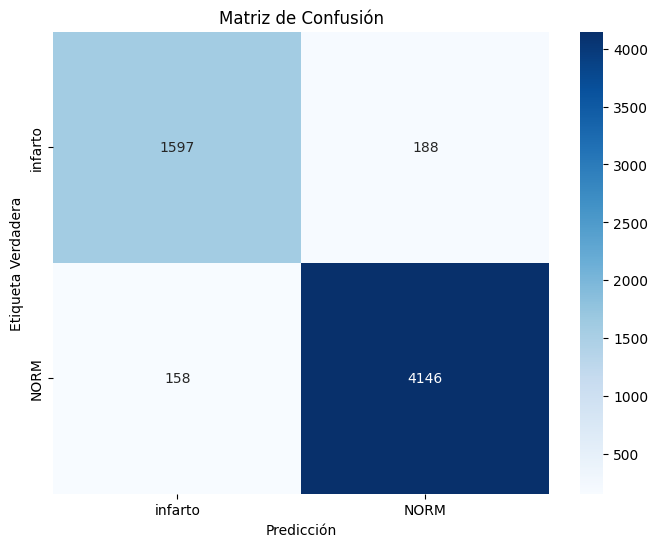

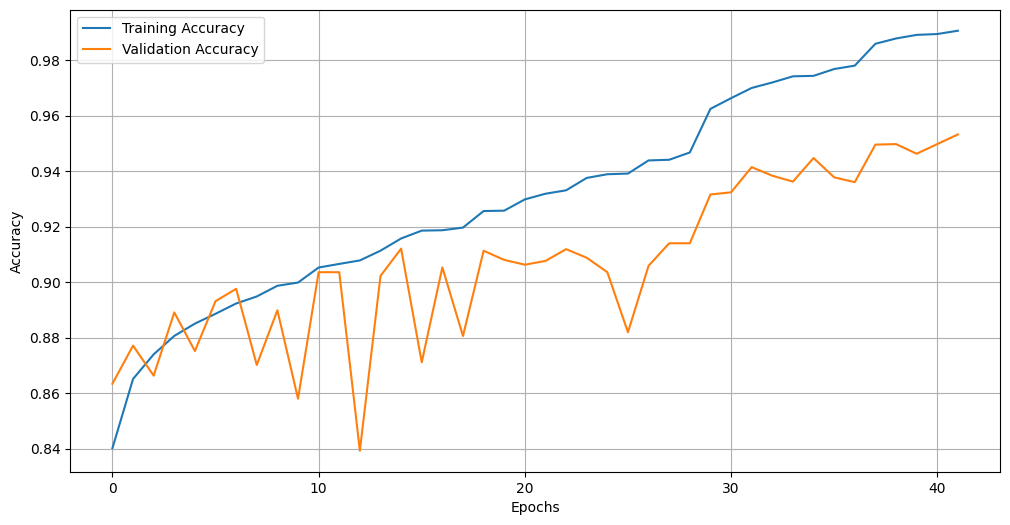

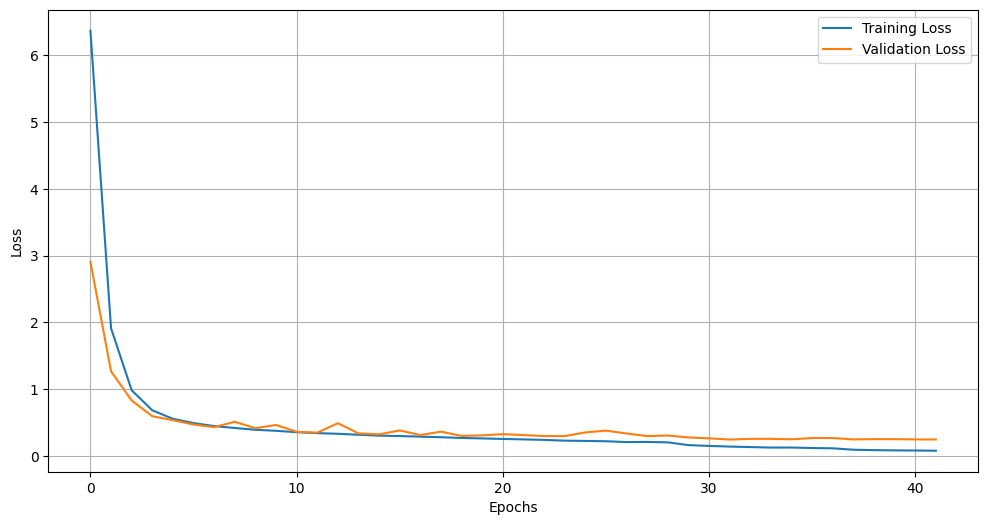

Modelo guardado exitosamente como alexnet_ecg_model_augmented.h5


In [44]:
if __name__ == "__main__":
    data_dir = "C:\\Users\\fabia\\Desktop\\categorized100_csv"
    records, labels, label_map = load_and_denoise_csv_data_with_augmentation(data_dir, augment=True)
    records, labels = preprocess_data(records, labels, num_classes=len(label_map))

    x_train, x_val, x_test, y_train, y_val, y_test = split_data(records, labels, test_size=0.15, val_size=0.15)

    input_shape = x_train.shape[1:]
    num_classes = y_train.shape[1]
    model = build_alexnet(input_shape, num_classes)

    history = train_model(model, x_train, y_train, x_val, y_val)

    class_names = list(label_map.keys())
    cm, f1, recall = evaluate_model(model, x_test, y_test, class_names)

    plot_confusion_matrix(cm, class_names)
    plot_training(history)

    model.save("alexnet_ecg_model_augmented.h5")
    print("Modelo guardado exitosamente como alexnet_ecg_model_augmented.h5")


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
               precision    recall  f1-score   support

     infarto       0.91      0.89      0.90      1785
        NORM       0.96      0.96      0.96      4304

    accuracy                           0.94      6089
   macro avg       0.93      0.93      0.93      6089
weighted avg       0.94      0.94      0.94      6089


Confusion Matrix:
 [[1597  188]
 [ 158 4146]]

F1-Score (weighted): 0.9430
Recall (weighted): 0.9432


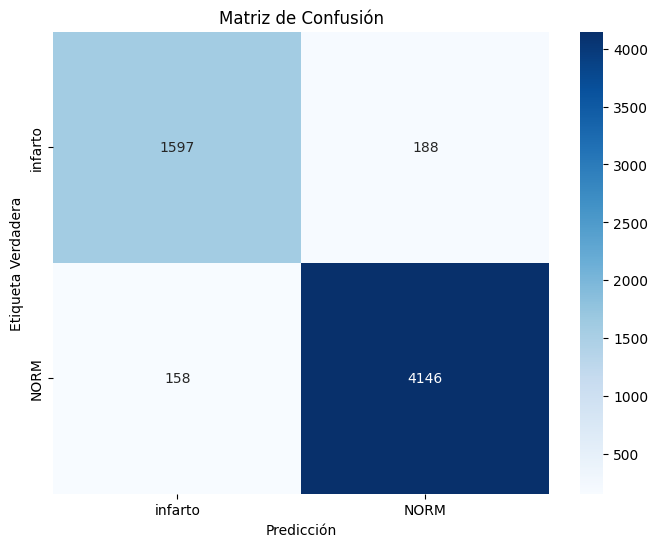

In [45]:
cm, f1, recall = evaluate_model(model, x_test, y_test, class_names)
plot_confusion_matrix(cm, class_names)
